# Unsupervised Learning: KMeans Clustering for Customer Segmentation

## What is Unsupervised Learning?

**Simple explanation:** We give the computer data without telling it what groups to look for. The computer finds patterns and creates groups on its own.

Think of it like organizing a messy closet:
- **Supervised:** You tell the computer "clothes go here, shoes go there"
- **Unsupervised:** The computer looks at everything and says "I see 5 types of things, let me group them"

## Why Use This?

✅ **No bias** — We don't force customers into categories we think should exist  
✅ **Discover patterns** — Might find groups we never thought of  
✅ **Data-driven** — Based on actual customer behavior, not assumptions  

## What We'll Do

1. **Prepare data** for machine learning
2. **Find optimal number of clusters** using statistical methods
3. **Create customer segments** using KMeans
4. **Evaluate quality** of the clusters
5. **Profile each segment** for business use


### Step 1: Import libraries & setup
Load core packages for data handling, visualization, and clustering, and configure plotting style for the analysis.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.float_format = '{:.2f}'.format

print("✅ Libraries loaded")


✅ Libraries loaded


### Step 2: Load and Understand the RFM Data
Load the pre-computed RFM (Recency, Frequency, Monetary) dataset. This dataset aggregates customer behavior:

Recency: Days since last purchase.
Frequency: Number of purchases.
Monetary: Total amount spent.

We print an overview and sample to verify the data.

In [2]:
# Load RFM data
rfm = pd.read_csv("../data/processed/rfm_scores.csv")

print(f"📊 Dataset Overview:")
print(f"   Total customers: {len(rfm):,}")
print(f"   Features: {list(rfm.columns)}")
print(f"\n✅ We'll use these 3 features for clustering:")
print(f"   1. Recency (days since last purchase)")
print(f"   2. Frequency (number of purchases)")
print(f"   3. Monetary (total amount spent)")

# Show sample
print(f"\nSample data:")
rfm[['CustomerID', 'recency_days', 'frequency', 'monetary']].head()


📊 Dataset Overview:
   Total customers: 879,358
   Features: ['CustomerID', 'recency_days', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score', 'segment']

✅ We'll use these 3 features for clustering:
   1. Recency (days since last purchase)
   2. Frequency (number of purchases)
   3. Monetary (total amount spent)

Sample data:


,CustomerID,recency_days,frequency,monetary
0,C1010011,26,2,5106.00
1,C1010012,69,1,1499.00
2,C1010014,76,2,1455.00
3,C1010018,37,1,30.00
4,C1010024,65,1,5000.00


### Step 3: Inspect Feature Distributions
Before clustering, we assess the skewness and distribution of RFM features. High skewness may require log-transformation to stabilize variance and improve cluster quality. We compute skewness and visualize histograms.


📈 Skewness of each feature:
   recency_days    : -0.228
   frequency       : 2.609


   monetary        : 43.308


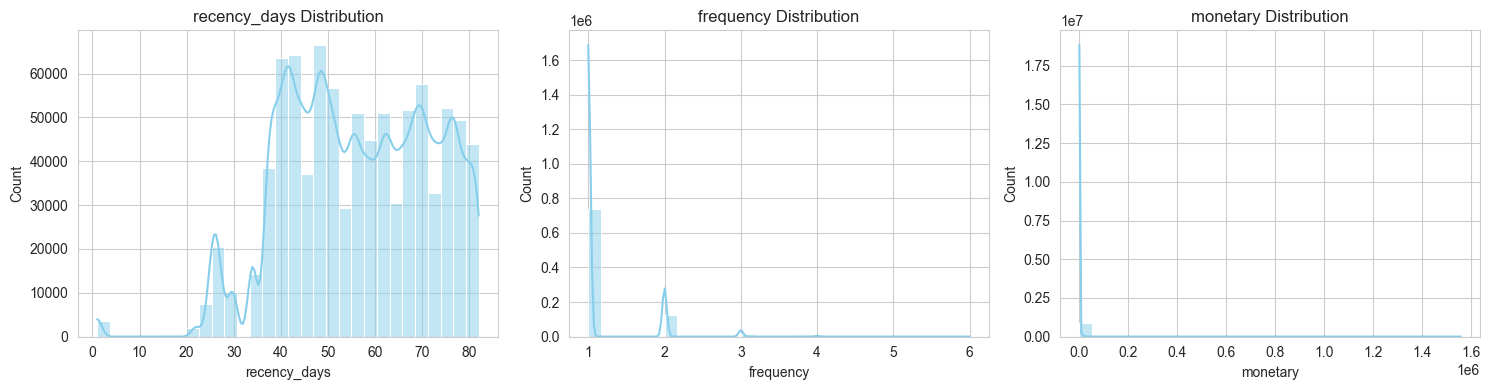


⚠️ Highly skewed features (> |1|): ['frequency', 'monetary']
   → Consider applying log or Box-Cox transformation before scaling.


In [3]:
# Check distribution and skewness before scaling
from scipy.stats import skew

# Select the 3 features
features = rfm[['recency_days', 'frequency', 'monetary']].copy()

print("\n📈 Skewness of each feature:")
for col in features.columns:
    print(f"   {col:<15} : {features[col].skew():.3f}")

# Visualize distributions
plt.figure(figsize=(15, 4))
for i, col in enumerate(features.columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(features[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# Optional: Log-transform highly skewed features for visualization
skewed_features = [col for col in features.columns if abs(features[col].skew()) > 1]

if skewed_features:
    print(f"\n⚠️ Highly skewed features (> |1|): {skewed_features}")
    print("   → Consider applying log or Box-Cox transformation before scaling.")
else:
    print("\n✅ All features have acceptable skewness (|skew| ≤ 1).")


### Step 4: Reduce skew with log transform
Apply a logarithmic transform to highly skewed variables (typically frequency/monetary) to stabilize variance.


📈 Skewness after log1p:
   recency_days    : -0.228
   frequency       : 2.202
   monetary        : -0.211


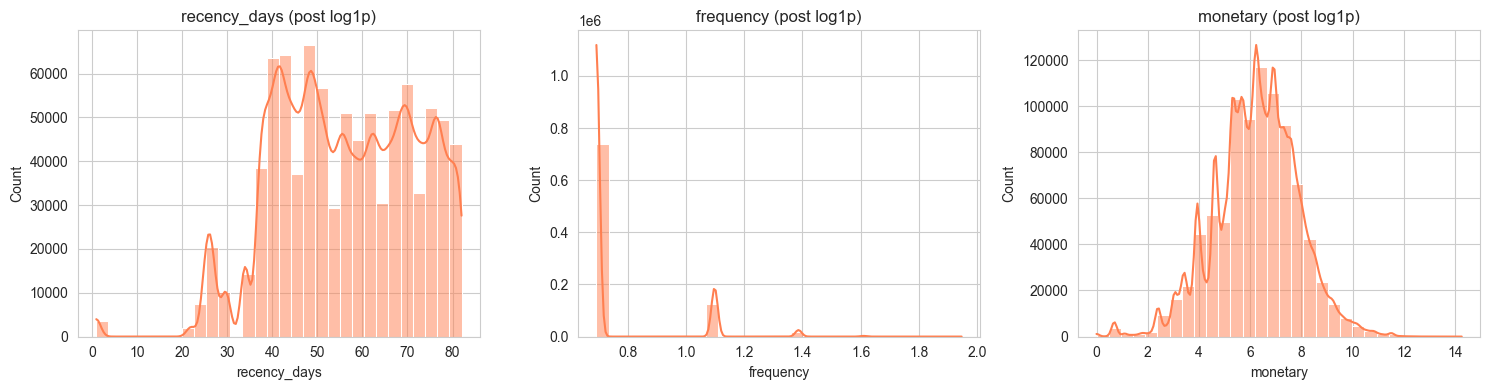

In [4]:
# Apply log1p to reduce skew (keep recency as-is for now)
features_t = features.copy()
features_t['frequency'] = np.log1p(features_t['frequency'])
features_t['monetary']  = np.log1p(features_t['monetary'])

print("\n📈 Skewness after log1p:")
for col in features_t.columns:
    print(f"   {col:<15} : {features_t[col].skew():.3f}")

# Visualize post-transform distributions
plt.figure(figsize=(15, 4))
for i, col in enumerate(features_t.columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(features_t[col], bins=30, kde=True, color='coral')
    plt.title(f'{col} (post log1p)')
plt.tight_layout()
plt.show()

### Step 5: Scale features
Scale transformed features (robust to outliers) so that no single feature dominates K-Means distance calculations.

In [ ]:
# Use transformed features from the previous cell
X = features_t.copy()  # if you switched to Yeo–Johnson earlier, use features_yj instead

scaler = RobustScaler()
features_scaled = scaler.fit_transform(X)
features_scaled_df = pd.DataFrame(features_scaled, columns=['recency_scaled','frequency_scaled','monetary_scaled'])

print(features_scaled_df.describe())

       recency_scaled  frequency_scaled  monetary_scaled
count       879358.00         879358.00        879358.00
mean             0.01              0.07            -0.02
std              0.61              0.17             0.80
min             -2.20              0.00            -3.12
25%             -0.48              0.00            -0.49
50%              0.00              0.00             0.00
75%              0.52              0.00             0.51
max              1.04              1.25             3.97


### Step 6:
Compute inertia across candidate **K** values to visually guide the number of clusters.

In [ ]:
K_range = range(2, 11)
inertias, sils, dbs, chs = [], [], [], []

print(f"{'K':>3} | {'Inertia':>12} | {'Silhouette':>10} | {'Davies-B':>9} | {'Calinski-H':>12}")
print("-"*60)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
    labels = km.fit_predict(features_scaled)

    # Sample for silhouette to keep it fast
    sil = silhouette_score(features_scaled, labels, sample_size=10000, random_state=42)
    db  = davies_bouldin_score(features_scaled, labels)
    ch  = calinski_harabasz_score(features_scaled, labels)

    inertias.append(km.inertia_); sils.append(sil); dbs.append(db); chs.append(ch)
    print(f"{k:>3} | {km.inertia_:>12,.0f} | {sil:>10.4f} | {db:>9.4f} | {ch:>12,.0f}")

  K |      Inertia | Silhouette |  Davies-B |   Calinski-H
------------------------------------------------------------
  2 |      565,953 |     0.3303 |    1.1481 |      542,272
  3 |      411,124 |     0.3332 |    0.9912 |      538,842
  4 |      316,152 |     0.3377 |    0.9247 |      555,184
  5 |      261,449 |     0.3278 |    0.9205 |      549,511
  6 |      226,685 |     0.3237 |    0.9456 |      533,992
  7 |      202,755 |     0.3122 |    0.9699 |      514,808
  8 |      183,250 |     0.3092 |    0.9686 |      501,603
  9 |      166,915 |     0.2996 |    0.9462 |      492,615
 10 |      153,375 |     0.2965 |    0.9651 |      485,160


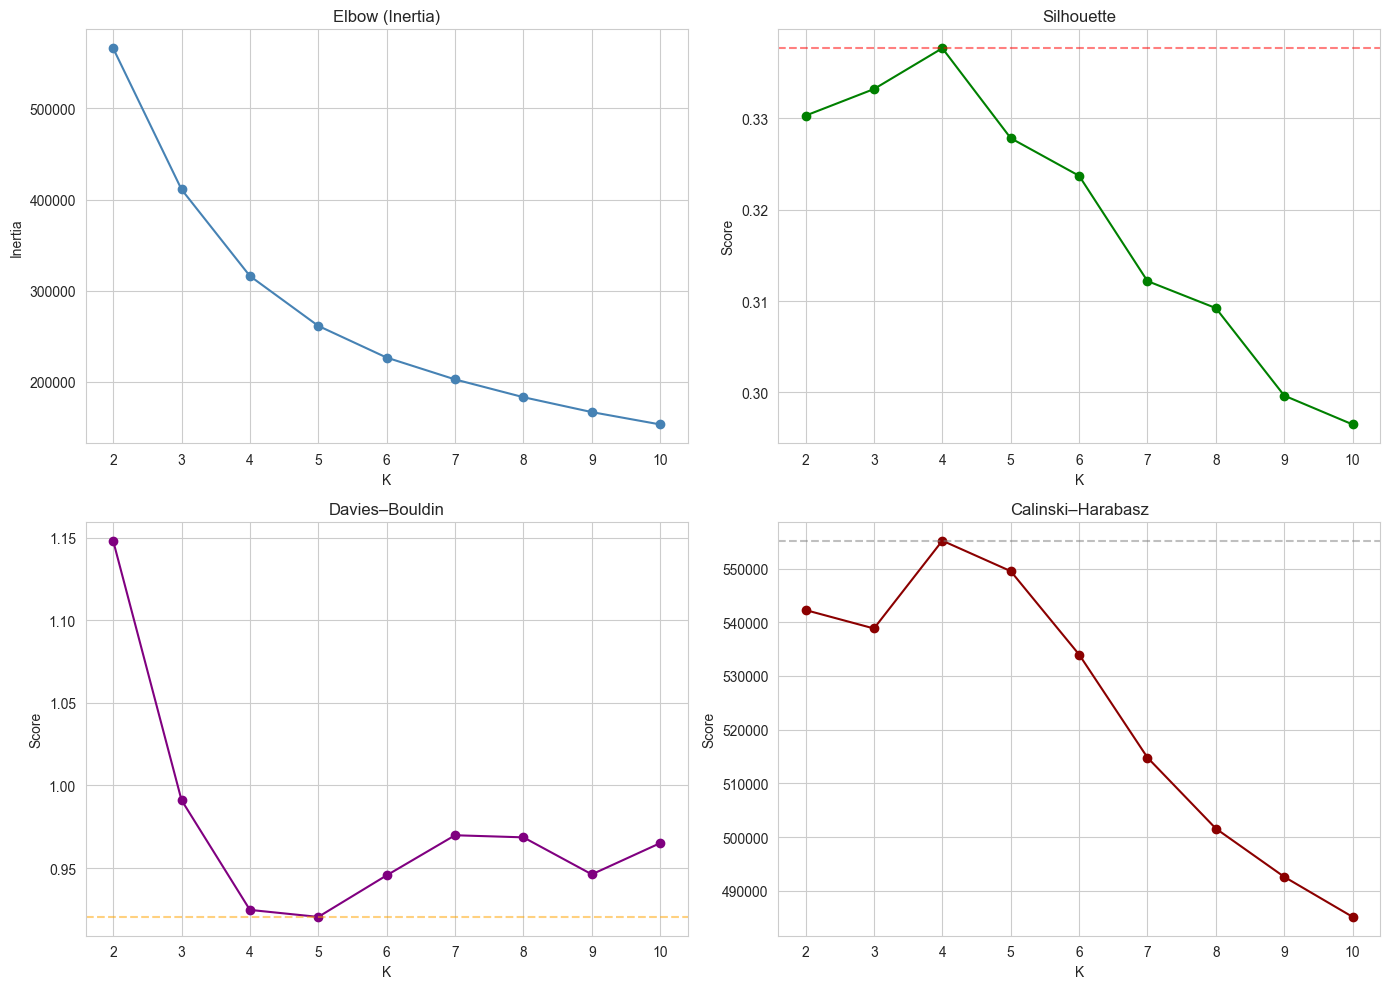

In [10]:
import matplotlib.pyplot as plt
import numpy as np

Ks = list(K_range)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Inertia (Elbow)
axes[0,0].plot(Ks, inertias, 'o-', color='steelblue')
axes[0,0].set_title('Elbow (Inertia)')
axes[0,0].set_xlabel('K'); axes[0,0].set_ylabel('Inertia')

# Silhouette (higher better)
axes[0,1].plot(Ks, sils, 'o-', color='green')
axes[0,1].axhline(max(sils), ls='--', color='red', alpha=0.5)
axes[0,1].set_title('Silhouette')
axes[0,1].set_xlabel('K'); axes[0,1].set_ylabel('Score')

# Davies-Bouldin (lower better)
axes[1,0].plot(Ks, dbs, 'o-', color='purple')
axes[1,0].axhline(min(dbs), ls='--', color='orange', alpha=0.5)
axes[1,0].set_title('Davies–Bouldin')
axes[1,0].set_xlabel('K'); axes[1,0].set_ylabel('Score')

# Calinski–Harabasz (higher better)
axes[1,1].plot(Ks, chs, 'o-', color='darkred')
axes[1,1].axhline(max(chs), ls='--', color='gray', alpha=0.5)
axes[1,1].set_title('Calinski–Harabasz')
axes[1,1].set_xlabel('K'); axes[1,1].set_ylabel('Score')

plt.tight_layout()
plt.show()

### Step 8:Train K-Means and assign segments
Fit K-Means on the scaled features and attach the resulting cluster labels back to each customer in the RFM table.

In [ ]:
k_selected = 4

final_kmeans = KMeans(
    n_clusters=k_selected,
    random_state=42,
    n_init=20,
    max_iter=500
)
labels = final_kmeans.fit_predict(features_scaled)
rfm['Cluster'] = labels

print(f"✅ Created {k_selected} clusters")
print("\nCluster distribution:")
print(rfm['Cluster'].value_counts().sort_index())

# Quality metrics
sil = silhouette_score(features_scaled, labels, sample_size=10000, random_state=42)
db  = davies_bouldin_score(features_scaled, labels)
ch  = calinski_harabasz_score(features_scaled, labels)
print(f"\nSilhouette: {sil:.4f} | Davies–Bouldin: {db:.4f} | Calinski–Harabasz: {ch:,.0f}")

✅ Created 4 clusters

Cluster distribution:
Cluster
0    186881
1    161647
2    274054
3    256776
Name: count, dtype: int64

Silhouette: 0.3375 | Davies–Bouldin: 0.9252 | Calinski–Harabasz: 554,281


### Step 9: Build segment profiles
Aggregate RFM statistics by cluster to understand size, value, and behavioral patterns of each segment.

In [12]:
cluster_profiles = (
    rfm.groupby('Cluster')
       .agg(
           Customers=('CustomerID','count'),
           Recency_Mean=('recency_days','mean'),
           Frequency_Mean=('frequency','mean'),
           Monetary_Mean=('monetary','mean')
       )
       .round(2)
)
cluster_profiles['Percentage'] = (cluster_profiles['Customers'] / len(rfm) * 100).round(1)
print("\n📊 Cluster profiles (key metrics):")
print(cluster_profiles[['Customers','Percentage','Recency_Mean','Frequency_Mean','Monetary_Mean']])


📊 Cluster profiles (key metrics):
         Customers  Percentage  Recency_Mean  Frequency_Mean  Monetary_Mean
Cluster                                                                    
0           272792       31.00         70.73            1.08         845.07
1           258652       29.40         42.37            1.21         555.48
2           187972       21.40         51.64            1.44        6631.89
3           159942       18.20         59.73            1.02          65.34


### Step 10: Compute Segment Metrics
Calculate key business metrics for each cluster, such as customer count, revenue contribution, medians for RFM, percentages of recent/high-spend/repeat customers, and top 1% revenue share within cluster. This helps profile the segments.

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore

# Rebuild lightweight profiles
profiles = (
    rfm.groupby('Cluster')
       .agg(
           Customers=('CustomerID','count'),
           Recency_Mean=('recency_days','mean'),
           Frequency_Mean=('frequency','mean'),
           Monetary_Mean=('monetary','mean'),
           Revenue_Sum=('monetary','sum')
       )
       .round(2)
)
profiles['Percentage'] = (profiles['Customers'] / len(rfm) * 100).round(1)
profiles['Revenue_%']  = (profiles['Revenue_Sum'] / profiles['Revenue_Sum'].sum() * 100).round(1)

# Global thresholds (original units)
rec_p30 = np.percentile(rfm['recency_days'], 30)
rec_p50 = np.percentile(rfm['recency_days'], 50)
rec_p70 = np.percentile(rfm['recency_days'], 70)
freq_p60 = np.percentile(rfm['frequency'], 60)
freq_p80 = np.percentile(rfm['frequency'], 80)
mon_p70  = np.percentile(rfm['monetary'], 70)
mon_p90  = np.percentile(rfm['monetary'], 90)

# Percentile position of cluster means (cheap: only 4 clusters)
profiles['Recency_Pctl']   = profiles['Recency_Mean'].apply(lambda v: percentileofscore(rfm['recency_days'], v))
profiles['Frequency_Pctl'] = profiles['Frequency_Mean'].apply(lambda v: percentileofscore(rfm['frequency'], v))
profiles['Monetary_Pctl']  = profiles['Monetary_Mean'].apply(lambda v: percentileofscore(rfm['monetary'], v))

print("Global thresholds:", {
    'rec_p30': round(rec_p30,2), 'rec_p50': round(rec_p50,2), 'rec_p70': round(rec_p70,2),
    'freq_p60': round(freq_p60,2), 'freq_p80': round(freq_p80,2),
    'mon_p70': round(mon_p70,2), 'mon_p90': round(mon_p90,2)
})
cols = ['Customers','Percentage','Revenue_Sum','Revenue_%',
        'Recency_Mean','Recency_Pctl','Frequency_Mean','Frequency_Pctl',
        'Monetary_Mean','Monetary_Pctl']
print("\nCluster analysis (sorted by revenue):")
print(profiles[cols].sort_values('Revenue_Sum', ascending=False).to_string())

Global thresholds: {'rec_p30': np.float64(47.0), 'rec_p50': np.float64(56.0), 'rec_p70': np.float64(67.0), 'freq_p60': np.float64(1.0), 'freq_p80': np.float64(1.0), 'mon_p70': np.float64(1200.0), 'mon_p90': np.float64(3550.0)}

Cluster analysis (sorted by revenue):
         Customers  Percentage   Revenue_Sum  Revenue_%  Recency_Mean  Recency_Pctl  Frequency_Mean  Frequency_Pctl  Monetary_Mean  Monetary_Pctl
Cluster                                                                                                                                          
2           187972       21.40 1246610538.58      76.40         51.64         41.77            1.44           83.86        6631.89          95.28
0           272792       31.00  230529395.90      14.10         70.73         77.75            1.08           83.86         845.07          60.82
1           258652       29.40  143676417.30       8.80         42.37         20.92            1.21           83.86         555.48          50.98
3   

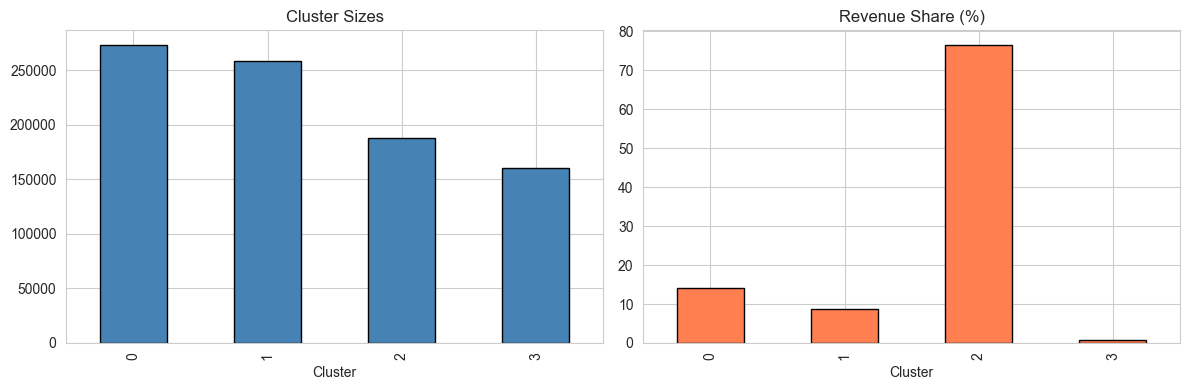

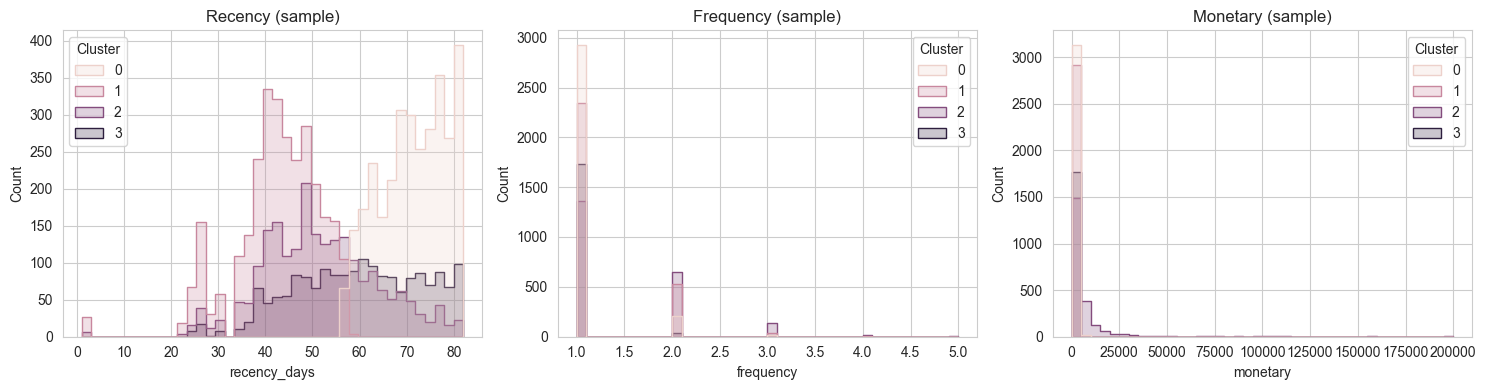

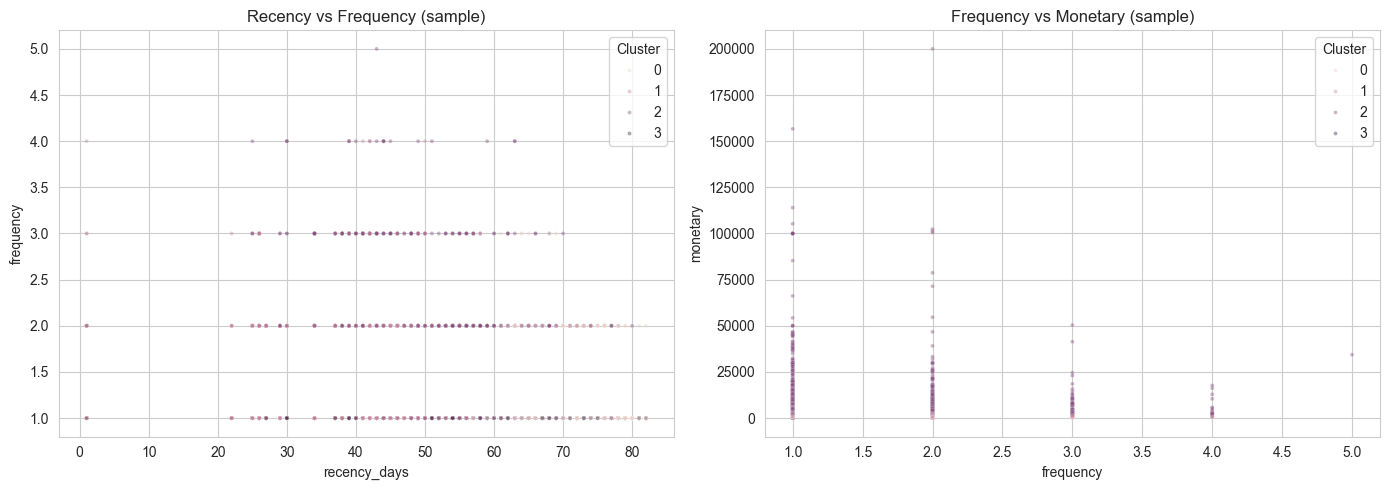

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sample = rfm.sample(n=min(10000, len(rfm)), random_state=42)

# Cluster sizes and revenue share (fast bars)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
rfm['Cluster'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black', title='Cluster Sizes')
(rfm.groupby('Cluster')['monetary'].sum()/rfm['monetary'].sum()*100
 ).sort_index().plot(kind='bar', ax=axes[1], color='coral', edgecolor='black', title='Revenue Share (%)')
plt.tight_layout()
plt.show()

# Distributions (sampled)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(sample, x='recency_days', hue='Cluster', bins=40, ax=axes[0], element='step', stat='count')
axes[0].set_title('Recency (sample)')
sns.histplot(sample, x='frequency', hue='Cluster', bins=40, ax=axes[1], element='step', stat='count')
axes[1].set_title('Frequency (sample)')
sns.histplot(sample, x='monetary', hue='Cluster', bins=40, ax=axes[2], element='step', stat='count')
axes[2].set_title('Monetary (sample)')
plt.tight_layout()
plt.show()

# Simple 2D structure (sample)
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(data=sample, x='recency_days', y='frequency', hue='Cluster', s=8, alpha=0.4, ax=axes[0])
axes[0].set_title('Recency vs Frequency (sample)')
sns.scatterplot(data=sample, x='frequency', y='monetary', hue='Cluster', s=8, alpha=0.4, ax=axes[1])
axes[1].set_title('Frequency vs Monetary (sample)')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# uses thresholds you already computed: rec_p30, mon_p70, mon_p90
g = rfm.groupby('Cluster')

def top1_rev_share(x):
    n = max(1, int(0.01*len(x)))
    total = x['monetary'].sum()
    return (x['monetary'].nlargest(n).sum() / total * 100) if total > 0 else 0.0

metrics = pd.DataFrame({
    'Customers': g.size(),
    'Revenue_Sum': g['monetary'].sum(),
    'Revenue_%': g['monetary'].sum().pipe(lambda s: s/s.sum()*100),
    'Recency_Median': g['recency_days'].median(),
    'Frequency_Median': g['frequency'].median(),
    'Monetary_Median': g['monetary'].median(),
    'Recent_%(<=p30)': g.apply(lambda x: (x['recency_days'] <= rec_p30).mean()*100),
    'HighSpend90_%(>=p90)': g.apply(lambda x: (x['monetary'] >= mon_p90).mean()*100),
    'MidHigh70_90_%': g.apply(lambda x: ((x['monetary'] >= mon_p70) & (x['monetary'] < mon_p90)).mean()*100),
    'Repeaters_%(freq>=2)': g.apply(lambda x: (x['frequency'] >= 2).mean()*100),
    'Top1%_RevShare_%': g.apply(top1_rev_share)
}).round(2)

print(metrics.sort_values('Revenue_Sum', ascending=False).to_string())

C:\Users\user\AppData\Local\Temp\ipykernel_9548\1610883665.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Recent_%(<=p30)': g.apply(lambda x: (x['recency_days'] <= rec_p30).mean()*100),
C:\Users\user\AppData\Local\Temp\ipykernel_9548\1610883665.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'HighSpend90_%(>=p90)': g.apply(lambda x: (x['monetary'] >= mon_p90).mean()*100),
C:\Users\user\AppData\L

         Customers   Revenue_Sum  Revenue_%  Recency_Median  Frequency_Median  Monetary_Median  Recent_%(<=p30)  HighSpend90_%(>=p90)  MidHigh70_90_%  Repeaters_%(freq>=2)  Top1%_RevShare_%
Cluster                                                                                                                                                                                      
2           187972 1246610538.58      76.42           50.00              1.00          3197.60            38.46                 45.01           53.83                 36.33             15.91
0           272792  230529395.90      14.13           71.00              1.00           595.00             0.00                  1.21           20.54                  7.61              5.22
1           258652  143676417.30       8.81           43.00              1.00           457.00            68.17                  0.03            7.28                 19.28              3.88
3           159942   10451249.94       0.64       

C:\Users\user\AppData\Local\Temp\ipykernel_9548\1610883665.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Top1%_RevShare_%': g.apply(top1_rev_share)


### Step 13: Assign Segment Names and Business Summary
Based on the cluster profiles from metrics, map numeric clusters to meaningful names. Then compute a business summary with averages and revenue shares.

In [ ]:
# Simple mapping from observed profiles (K=4)
cluster_to_segment = {
    2: 'High Value',          # 76% revenue, very high monetary
    0: 'At Risk',             # high recency, middling spend
    1: 'Recent Low Value',    # recent but low spend
    3: 'Dormant'              # negligible revenue, very low spend
}

rfm['Segment_Name'] = rfm['Cluster'].map(cluster_to_segment)

# Quick business summary
biz = (rfm.groupby('Segment_Name')
          .agg(Customers=('CustomerID','count'),
               Avg_Recency=('recency_days','mean'),
               Avg_Frequency=('frequency','mean'),
               Avg_Spent=('monetary','mean'),
               Total_Revenue=('monetary','sum'))
          .round(2))
biz['Revenue_%'] = (biz['Total_Revenue'] / biz['Total_Revenue'].sum() * 100).round(1)
print(biz.sort_values('Total_Revenue', ascending=False).to_string())

                  Customers  Avg_Recency  Avg_Frequency  Avg_Spent  Total_Revenue  Revenue_%
Segment_Name                                                                                
At Risk              186881        50.94           1.45    6625.12  1238108335.54      75.90
High Value           274054        70.74           1.08     893.67   244914583.35      15.00
Dormant              256776        42.45           1.21     535.15   137414021.59       8.40
Recent Low Value     161647        60.06           1.02      67.00    10830661.24       0.70


### Step 14: Segment size check
Quick sanity check of how many customers fall into each segment.

In [8]:
rfm['Segment_Name'].value_counts()


Segment_Name
High Value          274054
Dormant             256776
At Risk             186881
Recent Low Value    161647
Name: count, dtype: int64

### Step 15: Preview labeled data
Display a sample of the RFM table with cluster assignments to verify the pipeline output.

In [14]:
rfm.head()

,CustomerID,recency_days,frequency,monetary,R_score,F_score,M_score,RFM_score,segment,Cluster,Segment_Name
0,C1010011,26,2,5106.00,5,5,5,555,Champions,0,At Risk
1,C1010012,69,1,1499.00,2,1,4,214,Others,2,High Value
2,C1010014,76,2,1455.00,1,5,4,154,Need Attention,2,High Value
3,C1010018,37,1,30.00,5,1,1,511,Others,1,Recent Low Value
4,C1010024,65,1,5000.00,2,1,5,215,Others,0,At Risk


### Step 16: Export results for visualization
Save the customer-level segment assignments to disk for use in the Streamlit dashboard.

In [ ]:
from pathlib import Path

out_dir = Path("data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

rfm[['CustomerID', 'recency_days', 'frequency', 'monetary', 'Cluster', 'Segment_Name']] \
    .to_csv(out_dir / 'kmeans_customer_segments.csv', index=False)


OSError: Cannot save file into a non-existent directory: '..data\processed'